In [94]:
# IMPORTS
import sys, glob,importlib, latex, itertools, os
sys.path.insert(0,'../../')
sys.path.insert(0,'/Library/TeX/texbin/')
sys.path.insert(0,'../../WaveformAnalysis')
import numpy as np
import Dataset as Dataset
import Waveform as Waveform
import SiPM as SiPM
import matplotlib.pyplot as plt
import matplotlib as mpl
import pprint
from natsort import natsorted
from datetime import datetime
import inspect
from scipy.signal import find_peaks, find_peaks_cwt
from scipy.optimize import curve_fit
import requests
from scipy.special import erfc
from ipywidgets import IntProgress
from IPython.display import display
import scipy.special

importlib.reload(Dataset)
importlib.reload(SiPM)
importlib.reload(Waveform)

# LOGGER SETTINGS AND VARIABLES
ANSI_RESET = '\u001b[0m'
ANSI_GREEN = '\u001b[32m'
ANSI_CYAN = '\u001b[36m'
ANSI_RED = '\u001b[31m'
ANSI_YELLOW = '\u001b[33m'
ANSI_BG_RED = '\u001b[41m'
ANSI_BG_GREEN = '\u001b[42m'

olderr = np.seterr(all='ignore') 
scipy.special.seterr(all='ignore')
import warnings
warnings.filterwarnings("ignore")

pp = pprint.PrettyPrinter(indent=4)

# MATPLOTLIB SETTINGS
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.dpi']= 200

# DATA SOURCE
#path = r'/gpfs/loomis/project/david_moore/aj487/Data_WL110/LXe_Setup/SiPM/20220630/LXe_Full_E_field_-2kV_source_reposition_PDE_waveforms/'
#path = r'/home/tb829/sipm_data/202206[0-1]*/'
path = r'/Users/tizi/Documents/YALE_WL.nosync/data/202206[0-1]*/'
files = glob.glob(path+'wave*')
voltages = np.unique([x.split('_')[-2] for x in files])

The voltages variable contains a list of all the voltages as strings 'X.XX'.
The files variable is a list of all the files under scrutiny.

In [95]:
from calendar import c


class Gat:  #   Gain Analysis Tool

    CHANNEL = 0 # TODO SET A CHANNEL FROM WHICH TO TAKE WAVEFORM DATA
    source_files = []
    voltages = []
    error = True
    SiPMs = {}
    shaping_time = 1e-5
    waveforms = {}

    def __init__(self, base_regex,filename_regex,shaping_time, silenced=False,debug=False,force=False,notify=False):
        self.update(60,'INIT')
        self.source_files = glob.glob(base_regex+filename_regex)
        self.voltages = [x.split('_')[-2] for x in self.source_files]
        self.voltages = np.array(sorted([float(x.split('OV')[0]) for x in self.voltages]))
        self.voltages = np.unique(self.voltages)
        self.notifications = notify
        if self.source_files is None or len(self.source_files) == 0:
            error = True
            raise(FileNotFoundError('Unable to locate source files located at '+(base_regex+filename_regex)))
        elif self.voltages is None or len(self.voltages) == 0:
            self.error = True
            raise(FileNotFoundError('The files you are trying to load are missing voltage information in their names i.e.'+self.source_files[0]))
        elif not type(shaping_time) is type(1e-1):
            self.error = True
            raise(ValueError('Shaping time must be a number. Only one shaping time per Gat object is allowed'))
        else:
            self.error = False
            self.silenced = silenced
            self.debug = debug
            self.shaping_time = shaping_time
            self.load_files(base_regex,filename_regex,force=force)
            self.log(f'{len(self.source_files)} files and {len(voltages)} voltages loaded',1)

    def __throw_error(self):
        raise(RuntimeError('The Gat object you are attempting to call has experienced an unexpected error and is unable to perform the method you requried at this time'))

    def load_files(self,base_regex,filename_regex,force=False):
        if self.error: self.__throw_error()
        if len(self.SiPMs.keys()) > 0 and not force:
            self.log('WARNING: files already loaded! Use the force optional argument to force load.',2)
            return
        if len(self.SiPMs.keys()) > 0 and force:
            self.log('Forcing to reload files....',2)

        for volt in self.voltages:
            self.SiPMs[volt] = SiPM.SiPM(Path=base_regex, Selection=filename_regex+'_{:.2f}OV*.h5'.format(volt))
            self.log(f'Loading {filename_regex}_{volt:.2f}OV*.h5 returned {len(self.SiPMs[volt].Files)} files',4)
            self.SiPMs[volt].Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

            for file in natsorted(self.SiPMs[volt].Files):
                self.SiPMs[volt].ImportDataFromHDF5(file, self.SiPMs[volt].Ch, var=[])
                self.SiPMs[volt].get_sampling()
                self.SiPMs[volt].shaping_time=[self.shaping_time]
                #self.SiPMs[volt].Ch[self.CHANNEL].SubtractBaseline(Data=self.SiPMs[volt].Ch[self.CHANNEL].Amp, cutoff=150)
                self.SiPMs[volt].setup_butter_filter() # calculate the butterworth filter coefficients
        

    def eval_waveform_func_fit(self, voltage, bounds=None,reload=False):
        #raise(NotImplementedError('Not ready yet!'))
        if self.error: self.__throw_error()
        voltage = float(voltage)
        if type(voltage) == float: pass
        else:
            self.error = True
            raise ValueError('Parameter voltage must be of type float or int. '+str(type(voltage))+' found instead')

        if bounds is None: bounds = [0,len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp[0])]

        try_loading = self.__open_coords(voltage)
        if not try_loading or reload:

            coords = [] #   x,y coordinate arrays organized in one tuple per waveform
            pks_tally = 0 #     keep track of how many peaks are found
            lost = 0

            self.log(f'Getting {len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp)} waveforms for {voltage:.2f}V [{bounds[0]}:{bounds[1]}]',1)

            f = IntProgress(value=0,min=0,max=len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp),step=1,description='Loading fit...',bar_style='info',layout={"width": "100%"})
            display(f)

            diffs = []

            for waveform in self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp: #loop over the waveforms inside the file
                x = [] #    must be same lenght as y. NOTE: array of arrays due to some waveforms having multiple peaks (found with other methods).
                y = [] #    must be same length as x. NOTE: array of arrays due to some waveforms having multiple peaks (found with other methos).
                f.value += 1
                start = datetime.now()
                p0 = self.__p0estimate(waveform,voltage)
                
                if p0 is None:
                    self.log('Error loading p0',4)
                    lost += 1
                    continue
                
                popt,pcov = None, None
                try:
                    popt,pcov = curve_fit(self.__wave_func,self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,waveform,p0=p0,maxfev=1000000)
                except Exception as e:
                    self.log(e,3)
                else:
                    if popt is None or pcov is None:
                        lost += 1
                    else:
                        func = self.__wave_func(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,*popt)
                        max_x,max_y = self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time[np.argmax(func)],func[np.argmax(func)]
                        if max_x < bounds[0] or max_x > bounds[1]: self.log(f'Skipping due to peak out of bounds at {max_x}x{max_y}',4)
                        self.log(f'Max {max_x}x{max_y}',4)
                        perr = np.sqrt(np.diag(pcov))[1]

                        if perr > 1.0:
                            lost += 1
                            self.log(f'Perr {perr}',4)
                            possible_pks = find_peaks(waveform,prominence=40)[0]
                            """ plt.title(f'P_error: {perr:.5f}')
                            if len(possible_pks) > 1:
                                for p in possible_pks:
                                    ppk_x = self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time[p]
                                    ppk_y = waveform[p]
                                    ax.scatter([ppk_x],[ppk_y],50,color='magenta',marker=11,zorder=4)
                                ax.scatter([max_x],[max_y],50,color='blue',marker='+',label='Fit max',zorder=3)
                                ax.plot(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,func,color='red',alpha=0.8,zorder=2)
                                ax.plot(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,waveform,zorder=1)
                                fig.canvas.draw()
                                fig.canvas.flush_events()
                            else:
                                continue
                                plt.plot(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,waveform,color='purple')
                                plt.plot(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,func,color='lime',alpha=0.8)
                                plt.scatter([max_x],[max_y],50,color='red',marker='+',label='Fit max')
                                plt.close() """
                        else:
                            x.append([max_x])
                            y.append([max_y])
                            pks_tally += 1
                            coords.append((x,y))
                
                end = datetime.now()
                diffs.append((end-start).total_seconds())
                if f.value % 30 == 0: self.update(int(((np.mean(diffs)*(len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp)-f.value)))),'FUNC%20FIT')
                print(f'Estimated time to completion: {float(np.mean(diffs)*(len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp)-f.value)/60):.01f} minutes',end='\r')

                if len(diffs) == 5: self.notify('Initated fit calc.',f'ETC: {float(np.mean(diffs)*(len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp)-f.value)/60):.01f} minutes',0)
            
            if len(x) != len(y): raise(RuntimeError('Returning list of peak coordinates of different lengths. x: '+str(len(x))+ ' y: '+str(len(y))+' for '+str(len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp))+' waveforms'))

            self.log(f'{pks_tally} peaks found for {len(self.SiPMs[voltage].Ch[self.CHANNEL].Amp)} waveforms. Loss: {lost} ({(float(lost/pks_tally)):.02f}%)',1)

            self.__save_coords(coords,voltage)
            return (self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp, coords)
        elif not reload:
            self.log('Loading from backup file',1)
            return (self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp, try_loading)

    def __save_coords(self, coords,voltage):
        filename = f'_backup_{voltage:.01f}.bd'
        with open(filename,'w') as file:
            for coordinates in coords:
                x = coordinates[0][0]
                y = coordinates[1][0]
                str_x = ''
                str_y = ''
                for x_coord in x: str_x += str(float(x_coord))+'%'
                for y_coord in y: str_y += str(float(y_coord))+'%'
                file.write(str_x[:-1]+'\n'+str_y[:-1]+'\n'+'@@@@'+'\n')
            file.close()
        return True
    
    def __open_coords(self,voltage):
        filename = f'_backup_{voltage:.01f}.bd'
        coords = []
        if os.path.exists(filename):
            with open(filename, 'r') as file:
                lines = file.readlines()
                lines = [line.replace('\n','') for line in lines]
                #pp.pprint(lines)
                for ii, line in enumerate(lines):
                    if str(line) == '@@@@':
                        str_x = lines[ii-2]
                        str_y = lines[ii-1]

                        x_vals = str_x.split('%')
                        y_vals = str_y.split('%')

                        x = [float(val) for val in x_vals]
                        y = [float(val) for val in y_vals]

                        coords.append(([x],[y]))

                file.close()
                #pp.pprint(coords)
                return coords
                #for line in file.readlines():
        else: return False
                    

    def __p0estimate(self,waveform,voltage):

        temp_peaks_ind = np.asarray(find_peaks(waveform,prominence=30)[0])
        if len(temp_peaks_ind) == 0 or temp_peaks_ind is None:
            self.log('Error loading p0: could not find any peaks',4) 
            #plt.plot(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,waveform,color='magenta')
            #plt.show()
            return None
        
        LIMIT = 800
        temp_peaks_ind = temp_peaks_ind[(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time[temp_peaks_ind]<LIMIT)]
        if len(temp_peaks_ind) == 0:
            plt.plot(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,waveform,color='magenta')
            plt.show()
            self.log('Error loading p0: could not find any peaks below '+str(LIMIT),4) 
            return None
        tallest_peak_ind = temp_peaks_ind[np.argmax([waveform[p] for p in temp_peaks_ind])]
        A_est = waveform[tallest_peak_ind]
        mu_est = self.SiPMs[float(4.00)].Ch[self.CHANNEL].Time[tallest_peak_ind]-6
        base_est = float(np.mean(waveform[1:10]))
        try:
            tau_est = np.abs(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time[np.where(waveform[tallest_peak_ind:] < (A_est)**(np.e**-1)+base_est)[0][0]] - self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time[tallest_peak_ind])
        except IndexError as e:
            self.log(e,4)
            return None
        except Exception as e: #when is index 0 out of bounds it is because the np.where function does not return any true values because that condition is never meth because it is not a regular wave. Probably just noise.
            self.log(f'Estimate error ({type(e)}: {e}',3)
            plt.plot(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Time,waveform,color='brown')
            plt.show()
            return None
        sigma_est = 1
        self.log(f'Estimating A: {A_est}    mu: {mu_est}    tau: {tau_est}  base: {base_est}    sigma: {sigma_est}',4)

        return [mu_est,A_est,tau_est,base_est,sigma_est]
        popt,pcov = curve_fit(self.wave_func)

        for ii, val in enumerate(sample):
            if ii > find_peaks(sample,prominence=30)[0] and np.abs(val) < sample_max - sample_max**(np.e**-1):
                prob_return_x = (ii)
                break

        est_tau = prob_return_x-prob_rise_x
        est_tau2 = Ds[volt].Ch[0].Time[prob_return_x] - Ds[volt].Ch[0].Time[prob_rise_x]

    def __wave_func(self, x, mu, A, tau, base,sigma):
        return base + A/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))

    def eval_waveform_argmax(self, voltage, bounds=None):
        if self.error: self.__throw_error()
        voltage = float(voltage)
        if type(voltage) == float: pass
        else:
            self.error = True
            raise ValueError('Parameter voltage must be of type float or int. '+str(type(voltage))+' found instead')

        if bounds is None: bounds = [0,len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp[0])]

        coords = [] #   x,y coordinate arrays organized in one tuple per waveform
        pks_tally = 0 #     keep track of how many peaks are found

        self.log(f'Gettig {len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp)} waveforms for {voltage:.2f}V [{bounds[0]}:{bounds[1]}]',1)
        
        for waveform in self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp: #loop over the waveforms inside the file
            filtered = self.SiPMs[float(voltage)].get_filtered_waveform(waveform) # return the filtered waveform
            x = [] #    must be same lenght as y. NOTE: array of arrays due to some waveforms having multiple peaks (found with other methods).
            y = [] #    must be same length as x. NOTE: array of arrays due to some waveforms having multiple peaks (found with other methos).
            
            for i,y1 in enumerate(filtered): #Iterates each wave filtered with a different shaping time
                peak_index = np.argmax(y1[bounds[0]:bounds[1]])+bounds[0] #Finds the index for max value in the waveform amplitude array
                peak_value = y1[peak_index] #Gets the max value from the array of amps
                pks_tally += 1
                x.append(peak_index)
                y.append(peak_value)
            
            coords.append((x,y))
        
        if len(x) != len(y): raise(RuntimeError('Returning list of peak coordinates of different lengths. x: '+str(len(x))+ ' y: '+str(len(y))+' for '+str(len(self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp))+' waveforms'))

        self.log(f'{pks_tally} peaks found for {len(self.SiPMs[voltage].Ch[self.CHANNEL].Amp)} waveforms.',0)

        return (self.SiPMs[float(voltage)].Ch[self.CHANNEL].Amp, coords)

    
    def peaks_test(self, voltage, maxfev=1000000):
        pass


    def eval_gain(self, voltage, waveform_fit=True,find_best=False,bin_width=5,distance=12,prominence=30,min=2,plot=False):
        if self.error: self.__throw_error()

        plt.figure(figsize=(10,5))
        plt.suptitle(f'Overvoltage: {voltage:.02f}V',fontsize=16)
        plt.subplot(1,2,1)
        peaks_coords = None
        if waveform_fit:
            peaks_coords = self.eval_waveform_func_fit(voltage)[1]
        else: peaks_coords = self.eval_waveform_argmax(voltage)[1]

        popt_list, perr_list = None, None
        peaks_coords = self.__peak_filter(peaks_coords)

        if not find_best:
            popt_list,perr_list = self.__get_peaks(peaks_coords,bin_width,prominence,distance,min,plot=plot)
        else:
            #   raise(NotImplementedError('Find best has not been implemented yet! Sorry ;)'))
            popt_list,perr_list = self.__find_best(peaks_coords)
        

        if popt_list is False:
            self.log(f'MAJOR ERROR: Cannot find best paramaters for find_peaks function! Cannot proceed. Review the bound.',3)
            return None

        if popt_list is None:
            self.log(f'MAJOR ERROR: Cannot find any peaks! Cannot proceed. Review the bound.',3)
            return None

        print()
        msg = ''
        print('Resulting peaks:')
        msg += 'Resulting peaks:\n'
        for ii,popt in enumerate(popt_list):
            perr = perr_list[ii]
            x_pos = popt[1]
            if perr == False:print(f'{ANSI_RED} * {x_pos:.16g} --> FIT FAILED{ANSI_RESET}')
            else:
                if perr == np.inf: print(f'{ANSI_BG_RED} * {x_pos:.16g} \u00b1 {perr:.16g}{ANSI_RESET}')
                elif perr < 1: print(f' * {x_pos:.16g} \u00b1 {ANSI_GREEN}{perr:.16g}{ANSI_RESET}')
                else: print(f' * {x_pos:.16g} \u00b1 {perr:.16g}')
                msg += f' * {x_pos:.10f} \u00b1 {perr:.10f}\n'
        plt.subplot(1,2,2)
        gain = self.__gain_from_peaks(popt_list,perr_list)
        plt.show()
        return gain


    def __gain_from_peaks(self, popt_list,perr_list):
        data = np.asarray([float(peak[1]) for peak in popt_list])
        errs = np.asarray([float(err) for err in perr_list])

        plt.errorbar(np.arange(1,len(data)+1,1),data,yerr=errs,fmt='o',ms=5,color='red',label='Peaks')
        popt, pcov = curve_fit(self.line,np.arange(1,len(data)+1,1),data,sigma=errs)
        plt.plot(np.arange(1,len(data)+1,1),self.line(np.arange(1,len(data)+1,1),*popt),color='black',ls="--",alpha=0.8)
        self.log(f'Gain: {popt[1]:.2f} \u00b1 {float(np.sqrt(np.diag(pcov)[1])):.2f}',1)
        return (float(popt[1]),float(np.sqrt(np.diag(pcov)[1])))


    def __find_best(self, peaks_coords,method=None):
        fits, errs = [], []

        bin_width_start = 1
        bin_width_stop = 10
        bin_width_step = 0.5

        prominence_start = 10
        prominence_stop = 100
        prominence_step = 5

        distance_start = 10
        distance_stop = 90
        distance_step = 2

        min_peaks = 5
        max_error = 2.0
        
        trials = {}
        last = None
        
        best = None
        temp_errs = []

        skipped = 0
        done = 0

        perms = [item for item in itertools.product(np.arange(bin_width_start, bin_width_stop,bin_width_step),np.arange(prominence_start, prominence_stop,prominence_step),np.arange(distance_start, distance_stop,distance_step))]
        
        f = IntProgress(value=0,min=0,max=len(perms),step=1,description='Loading perms...',bar_style='info',layout={"width": "100%"})
        display(f)
        diffs = []

        for p in perms:
            start = datetime.now()
            f.value += 1
            popt_list,perr_list = self.__get_peaks(peaks_coords,p[0],p[1],p[2],peaks_min=min_peaks,plot=False)
            if False in perr_list or np.inf in perr_list: skipped += 1
            else:
                trials[p] = (popt_list,perr_list)
                last = p
                combined = float(np.sum(perr_list))
                if not True in np.asarray(perr_list) > max_error:
                    temp_errs.append(combined)
                else: self.log('Not counting for too big err'+str(perr_list),4)
                if True in np.asarray(temp_errs) < combined: continue
                else:
                    self.log(np.asarray(temp_errs) < combined,4)
                    self.log(temp_errs,4)
                    self.log(f'Combined {combined}',4)
                    best = p
                done += 1
                self.log(f'Skipped {skipped} of {done+skipped}',4)
            
            end = datetime.now()
            diffs.append((end-start).total_seconds())
            if f.value % 30 == 0: self.update(int(((np.mean(diffs)*(len(perms)-f.value)))),'BEST%20FIT')
            print(f'Estimated time to completion: {float(np.mean(diffs)*(len(perms)-f.value)/60):.01f} minutes',end='\r')
            if len(diffs) == 5: self.notify('Initated gain calc.',f'ETC: {float(np.mean(diffs)*(len(perms)-f.value)/60):.01f} minutes',1)

        if not best is None: self.log(f'Best found at prominence {best[1]}, distance {best[2]}, bin width {best[0]} for {len(trials)} trials',1)
        else:
            self.log('Fatal error: could not load any peaks!',3)
            return (False,False)
        return self.__get_peaks(peaks_coords,*best,min_peaks,plot=True)
    
    def __peak_filter(self, peaks_coords):
        temp = []
        for wvf_tuple in peaks_coords:
            x,y = wvf_tuple
            max_index = np.argmax(y)
            temp.append((max_index,y[max_index]))

        return temp


    def __get_peaks(self, peaks_filtered, bin_width, prominence, distance, peaks_min,max_bins=1000,plot=False):

        y_data = np.asarray([])
        for xy_val in peaks_filtered:
            y_val = xy_val[1]
            y_data = np.append(y_data,y_val) #TODO GET RID OF NEGATIVE PEAKS
            #TODO GET SCALES
 
        #plt.hist(data,bins=np.arange(0,max_bins,bin_width))
        y,x = np.histogram(y_data,bins=np.arange(0,max_bins,bin_width))
        #plt.hist(data,bins=np.arange(0,max_bins,bin_width))
        x = np.asarray(x).reshape(-1)
        y = np.asarray(y).reshape(-1)
        x = x[:-1]  #   get rid of last bin end value. It makes x > y otherwise.
        if plot:
            plt.bar(x,y,color='royalblue',width=bin_width)
            plt.xlim(0,1000)

        peaks_indexes = find_peaks(y, prominence=prominence,distance=distance)[0]

        self.log(f'{len(peaks_indexes)} peaks found',4)
        if len(peaks_indexes) < peaks_min:
            #raise(BaseException('Peaks not found'))
            return (None,[False])

        gauss_fits_temp = []
        gauss_err_temp = []

        for ii, peak_index in enumerate(peaks_indexes):
            pk_Y = y[peak_index]
            x_idx = (y < 0.5 * pk_Y) & (x > x[peak_index])
            rs_x = x[np.where(x_idx)[0][0]]
            sigma_guess = np.abs(x[peak_index]-rs_x)

            cut = (x > x[peak_index]-sigma_guess) & (x < x[peak_index]+sigma_guess)

            try: popt,pcov = curve_fit(self.gauss, x[cut], y[cut], p0=[pk_Y,x[peak_index],sigma_guess])
            except Exception as e:
                if 'must not exceed func output vector' in str(e): self.log('Sigma too small. Could not fit gaussian!',4)
                else: self.log(str(e),3)
                #plt.close()
                gauss_fits_temp.append((pk_Y,x[peak_index]))
                gauss_err_temp.append(False)
                if plot: plt.scatter([x[peak_index]],[pk_Y],50,color='red',marker='+',label='No fit')
                if plot: plt.hlines([pk_Y],0,x[peak_index],linestyles="dotted",colors=['red'],linewidths=0.8)
                continue
            else:
                self.log(popt,4)
                gauss_fits_temp.append(popt)
                gauss_err_temp.append(np.sqrt(np.diag(pcov))[1])
                if np.sqrt(np.diag(pcov))[1] == np.inf and plot: plt.plot(x[cut],self.gauss(x[cut],*popt),'m',label='Bad fit')
                elif plot: plt.plot(x[cut],self.gauss(x[cut],*popt),'lime',label='Good fit')

                if plot:plt.scatter([x[peak_index]],[pk_Y],50,color='green',marker='+')
                if plot:plt.hlines([pk_Y],0,x[peak_index],linestyles="--",colors=['magenta'],linewidths=0.8)
                if plot:plt.hlines([popt[0]],0,popt[1],linestyles="--",colors=['green'],linewidths=0.8)
        #if plot: plt.show()

        return (gauss_fits_temp, gauss_err_temp)
            

    def gauss(self,x,a,mu,sigma): return (a*np.exp(-0.5*((x-mu)/sigma)**2))

    def line(self,x,m,c): return (m*x)+c

    def log(self, message, level, notify=0):
        curframe = inspect.currentframe()
        calframe = inspect.getouterframes(curframe, 2)

        if self.silenced: return False

        time_format = "%I:%M:%S%p"

        if level == 0:
            print(ANSI_RESET,f'[{datetime.now().strftime(time_format)} - {calframe[1][3]}]: ',message,ANSI_RESET)
        elif level == 1:
            print(ANSI_GREEN,f'[{datetime.now().strftime(time_format)} - {calframe[1][3]}]: ',message,ANSI_RESET)
        elif level == 2:
            print(ANSI_YELLOW,f'[{datetime.now().strftime(time_format)} - {calframe[1][3]}]: ',message,ANSI_RESET)
        elif level == 3:
            print(ANSI_RED,f'[{datetime.now().strftime(time_format)} - {calframe[1][3]}]: ',message,ANSI_RESET)
        elif level == 4 and self.debug:
            print(ANSI_CYAN,f'[{datetime.now().strftime(time_format)} - {calframe[1][3]}]: ',message,ANSI_RESET)

        return True

    def update(self, etc,task):
        try: requests.get('http://tizianobuzz.pythonanywhere.com/logger/update/'+str(etc)+'/'+str(task))
        except Exception: pass

    def notify(self,title,message,priority,users=['Tiziano']):
        if not self.notifications: return False
        accounts = {'Tiziano': "hwr043mln2xft1y"}
        url = "https://alertzy.app/send"
        status = True
        for user in users:
            try: params = {'accountKey': accounts[user], 'title' : title, 'message': message, 'priority': priority}
            except: status = False
            else: requests.post(url, data=params)
        return status
        

In [96]:
gatter = Gat(path, 'wave*',1e-5,debug=False,force=False,notify=True) #TODO implement function that only adds voltages that have loaded waveforms associated after loading them. So to avoid key errors!
print(gatter.voltages)

ConnectionError: HTTPConnectionPool(host='tizianobuzz.pythonanywhere.com', port=80): Max retries exceeded with url: /logger/update/60/INIT (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x12bf46f20>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

 [04:36:04PM - eval_waveform_func_fit]:  Loading from backup file 


IntProgress(value=0, bar_style='info', description='Loading perms...', layout=Layout(width='100%'), max=12960)

 [04:59:31PM - __find_best]:  Fatal error: could not load any peaks! 
 [04:59:31PM - eval_gain]:  MAJOR ERROR: Cannot find best paramaters for find_peaks function! Cannot proceed. Review the bound. 
 [04:59:31PM - eval_waveform_func_fit]:  Loading from backup file 


IntProgress(value=0, bar_style='info', description='Loading perms...', layout=Layout(width='100%'), max=12960)

 [05:23:28PM - __find_best]:  Fatal error: could not load any peaks! 
 [05:23:28PM - eval_gain]:  MAJOR ERROR: Cannot find best paramaters for find_peaks function! Cannot proceed. Review the bound. 
 [05:23:28PM - eval_waveform_func_fit]:  Loading from backup file 


IntProgress(value=0, bar_style='info', description='Loading perms...', layout=Layout(width='100%'), max=12960)

ConnectionError: HTTPConnectionPool(host='tizianobuzz.pythonanywhere.com', port=80): Max retries exceeded with url: /logger/update/340/BEST%20FIT (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x13b276470>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

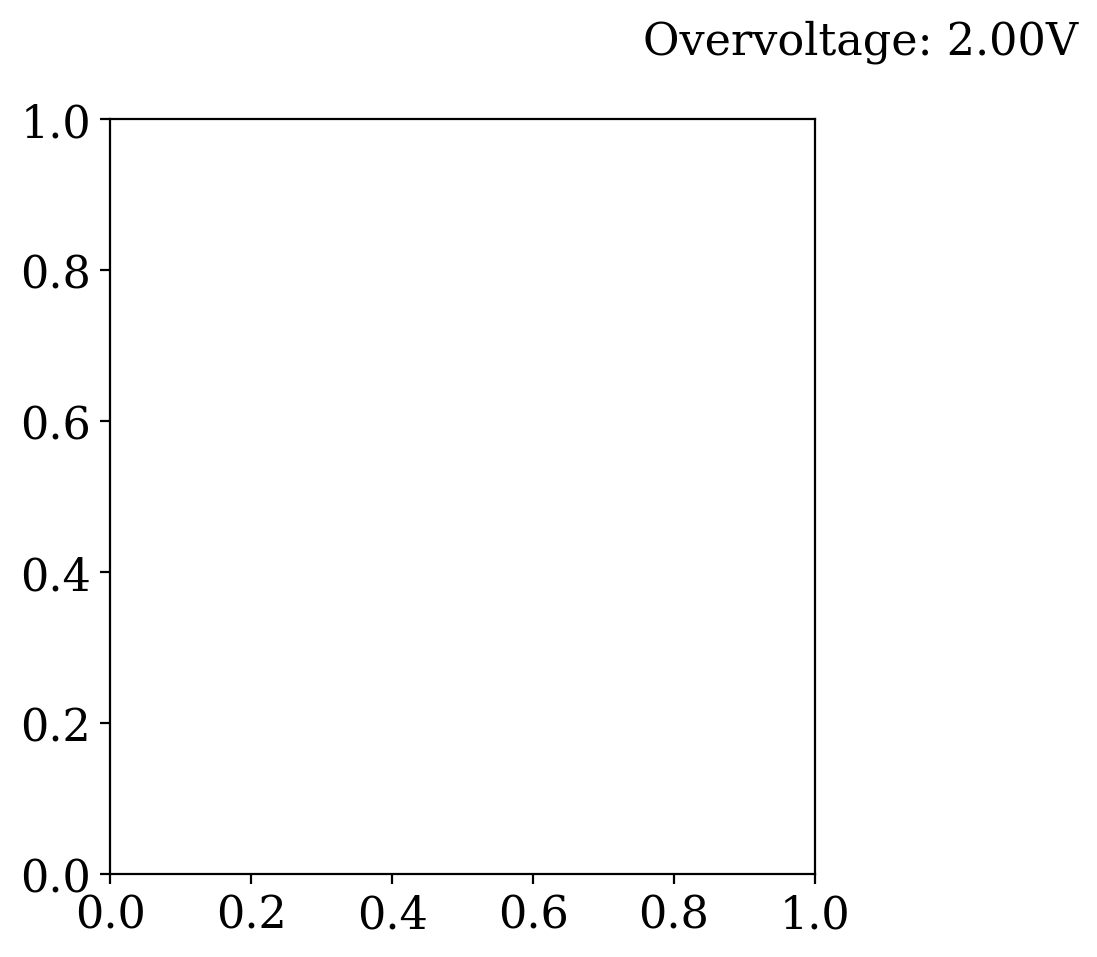

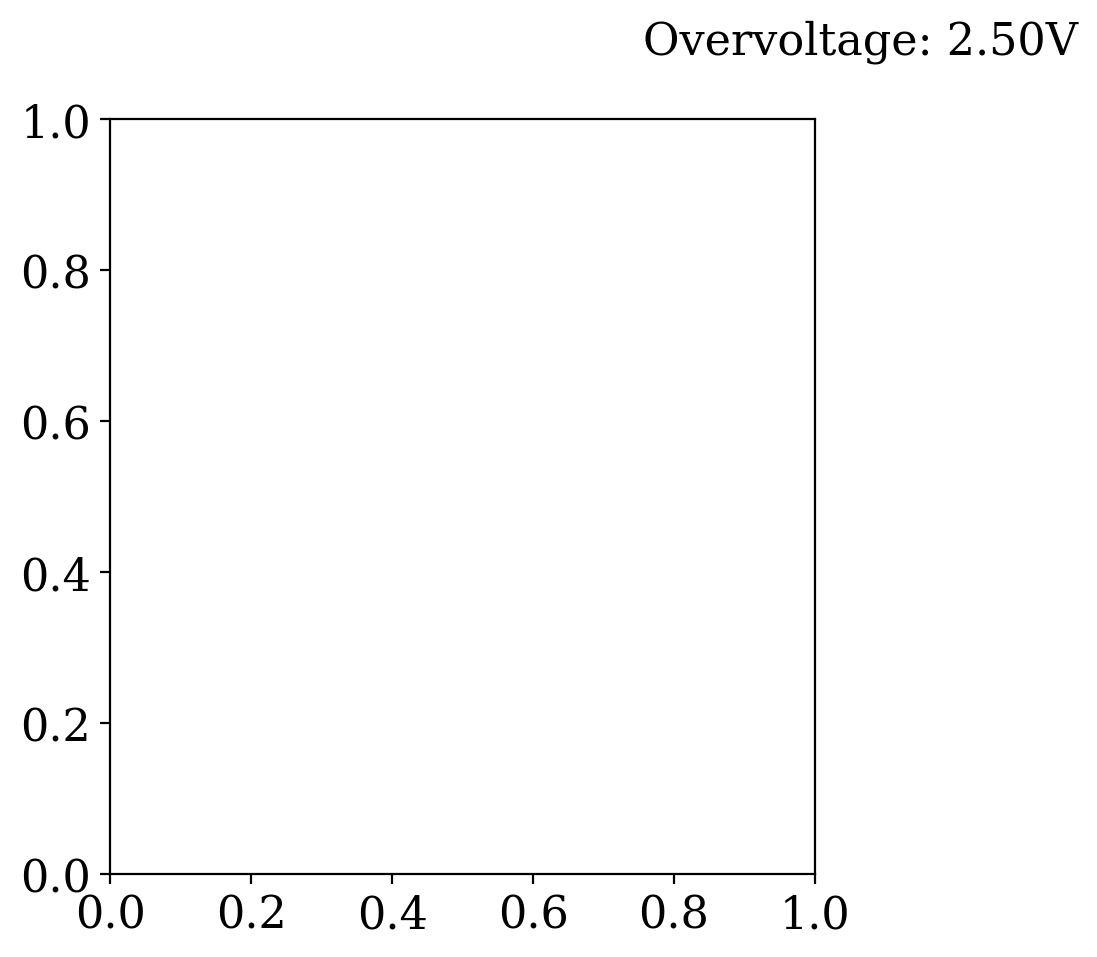

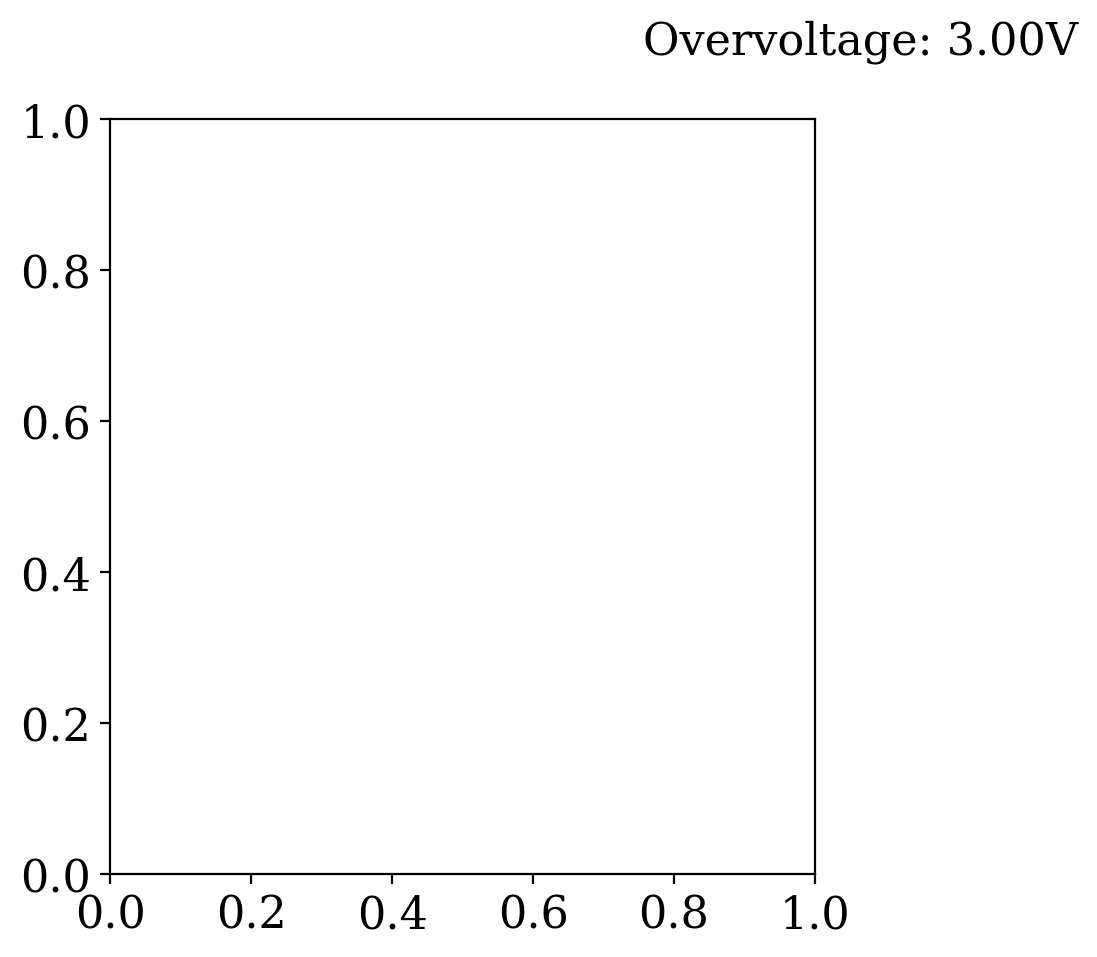

In [ ]:
#waves, peaks = gatter.eval_waveform_argmax(4.00,bounds=[390,396])
for volt in gatter.voltages:
    gatter.eval_gain(volt,plot=True,find_best=True)
gatter.notify('Done','Loading completed!',0)

In [ ]:
print(type(eval))
if type(eval) is tuple:
    popt_list,perr_list = eval
    print()
    msg = ''
    print('Resulting peaks:')
    msg += 'Resulting peaks:\n'
    for ii,popt in enumerate(popt_list):
        perr = perr_list[ii]
        max_y = popt[0]
        if perr == False:print(f'{ANSI_RED} * {max_y:.16g} --> FIT FAILED{ANSI_RESET}')
        else:
            if perr == np.inf: print(f'{ANSI_BG_RED} * {max_y:.16g} \u00b1 {perr:.16g}{ANSI_RESET}')
            elif perr < 1: print(f' * {max_y:.16g} \u00b1 {ANSI_GREEN}{perr:.16g}{ANSI_RESET}')
            else: print(f' * {max_y:.16g} \u00b1 {perr:.16g}')
            msg += f' * {max_y:.10f} \u00b1 {perr:.10f}\n'
else:
    print(f'{ANSI_RED} Not a tuple. Cannot unpack eval_gain due to unexpected circumstances.{ANSI_RESET}')
    pp.pprint(eval)

#gatter.notify('Done loading peaks',eval,0)

<class 'tuple'>

Resulting peaks:


TypeError: 'float' object is not iterable